<a href="https://colab.research.google.com/github/dietmarja/LLM-Elements/blob/main/vector_db/pinecone_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Pincone for Similary Search

In [162]:
!pip install pinecone-client matplotlib
import pinecone
import pandas as pd
from pinecone import Pinecone, ServerlessSpec
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time


In [163]:
# Initialize Pinecone
pc = Pinecone(api_key="6288ed25-a37a-4c7e-b466-fe1862dd079d")

index_name = "docs-quickstart-index"


In [164]:
# Check if the index exists and delete it if it does
if index_name in pc.list_indexes().names():
    pc.delete_index(index_name)
    print("Existing index deleted")



Existing index deleted


In [165]:
# Create the index
pc.create_index(
    name=index_name,
    dimension=3,
    metric="euclidean",  # Available metrics: "euclidean"/"manhattan"/"dotproduct"/"cosine"
    spec=ServerlessSpec(
        cloud='aws',
        region='us-east-1'
    )
)

print("Index created successfully")

Index created successfully


In [166]:
# Connect to the index
index = pc.Index(index_name)
print("Connected to the index")

Connected to the index


In [167]:
# Create a DataFrame with vectors
df = pd.DataFrame(
    data={
        "id": ["v1", "v2", "v3", "v4", "v5", "v6", "v7", "v8", "v9", "v10","v11","v12", "v13", "v14","v15"],
        "vector": [
            [1.2, 2.3, 3.4],
            [1.15, 2.35, 3.2],
            [1.0, 2.0, 3.0],
            [2.0, 1.0, 1.0],
            [3.0, 2.0, 2.8],
            [3.2, 0.4, 0.9],
            [0.5, 0.5, 0.5],
            [2.5, 1.5, 1.5],
            [3.5, 2.5, 1.1],
            [2.0, 3.0, 1.6],
            [1.5, 2.4, 1.2],
            [0.1, 0.7, 3.4],
            [3.4, 1.3, 2.6],
            [2.7, 3.2, 0.1],
            [1.6, 3.4, 2.2]
        ]
    }
)

print("DataFrame created")

DataFrame created


In [168]:
# Verify vectors_to_upsert format
vectors_to_upsert = [(row.id, row.vector) for _, row in df.iterrows()]
for vector in vectors_to_upsert:
    assert isinstance(vector, tuple) and len(vector) == 2, "Each entry in vectors_to_upsert must be a tuple (id, vector)"
    assert isinstance(vector[0], str), "The first element of each tuple must be a string id"
    assert isinstance(vector[1], list) and len(vector[1]) == 3, "The second element of each tuple must be a list with three dimensions"

print(f"Vectors to upsert: {vectors_to_upsert}")


Vectors to upsert: [('v1', [1.2, 2.3, 3.4]), ('v2', [1.15, 2.35, 3.2]), ('v3', [1.0, 2.0, 3.0]), ('v4', [2.0, 1.0, 1.0]), ('v5', [3.0, 2.0, 2.8]), ('v6', [3.2, 0.4, 0.9]), ('v7', [0.5, 0.5, 0.5]), ('v8', [2.5, 1.5, 1.5]), ('v9', [3.5, 2.5, 1.1]), ('v10', [2.0, 3.0, 1.6]), ('v11', [1.5, 2.4, 1.2]), ('v12', [0.1, 0.7, 3.4]), ('v13', [3.4, 1.3, 2.6]), ('v14', [2.7, 3.2, 0.1]), ('v15', [1.6, 3.4, 2.2])]


In [169]:
# Upsert vectors into the index
response = index.upsert(vectors=vectors_to_upsert)
print("Upsert response:", response)

Upsert response: {'upserted_count': 15}


In [170]:
# Wait for a few seconds to ensure the upsert is processed
time.sleep(10)

In [171]:
# Describe index stats
index_stats = index.describe_index_stats()
print("Index stats after upsert:", index_stats)

Index stats after upsert: {'dimension': 3,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 15}},
 'total_vector_count': 15}


In [172]:
# Ensure vectors were upserted
assert index_stats['total_vector_count'] > 0, "No vectors were upserted into the index"
########

In [173]:
# Perform a query
query_vector = [1.1, 2.2, 3.3]
similarity_threshold = 100.01  # Set similarity threshold here
print("Query Vector:", query_vector)
query_result = index.query(
    vector=query_vector,
    top_k=3,
    include_values=True
)

print("Query Result:")
for match in query_result['matches']:
    print(f"ID: {match['id']}, Vector: {match['values']}")
    if match['values'] in [result['values'] for result in query_result['matches']]:
        print(f"ID: {match['id']}, Vector: {match['values']} (Similar)")
    else:
        print(f"ID: {match['id']}, Vector: {match['values']}")

Query Vector: [1.1, 2.2, 3.3]
Query Result:
ID: v1, Vector: [1.2, 2.3, 3.4]
ID: v1, Vector: [1.2, 2.3, 3.4] (Similar)
ID: v2, Vector: [1.15, 2.35, 3.2]
ID: v2, Vector: [1.15, 2.35, 3.2] (Similar)
ID: v3, Vector: [1.0, 2.0, 3.0]
ID: v3, Vector: [1.0, 2.0, 3.0] (Similar)


Similar vector found: [1.2, 2.3, 3.4]
Similar vector found: [1.15, 2.35, 3.2]
Similar vector found: [1.0, 2.0, 3.0]
Similar Vectors found. Plotting...


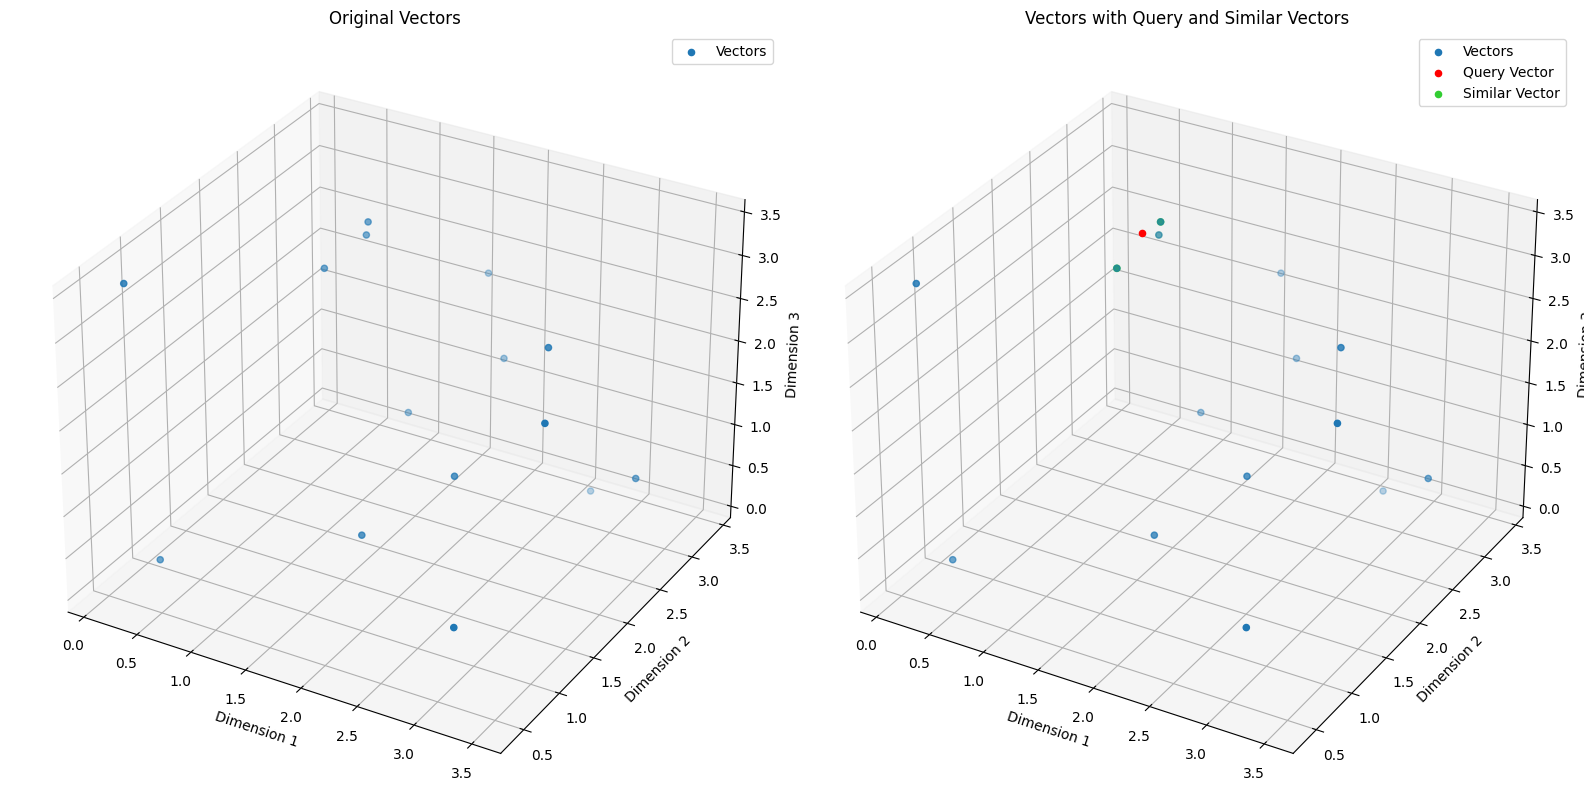

In [174]:
# Plotting the results
fig = plt.figure(figsize=(16, 8))

# Original vectors only (ax1)
ax1 = fig.add_subplot(121, projection='3d')
original_vectors = pd.DataFrame(df['vector'].tolist(), columns=['x', 'y', 'z'])
ax1.scatter(original_vectors['x'], original_vectors['y'], original_vectors['z'], label='Vectors')
ax1.set_title('Original Vectors')
ax1.set_xlabel('Dimension 1')
ax1.set_ylabel('Dimension 2')
ax1.set_zlabel('Dimension 3')
ax1.legend()

# Vectors with query and similar vectors (ax2)
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(original_vectors['x'], original_vectors['y'], original_vectors['z'], label='Vectors')
ax2.scatter(query_vector[0], query_vector[1], query_vector[2], color='red', label='Query Vector')

# Collect similar vectors
similar_vectors = []
for match in query_result['matches']:
    vector = match['values']
    if vector == query_vector:
        ax2.scatter(vector[0], vector[1], vector[2], color='red', marker='*', label='Query Vector')
    elif all(abs(query_vector[i] - vector[i]) < similarity_threshold for i in range(3)) and vector != query_vector:
        similar_vectors.append(vector)
        print("Similar vector found:", vector)  # Print the similar vector

# Plotting the similar vectors
if similar_vectors:
    print("Similar Vectors found. Plotting...")
    similar_vectors_df = pd.DataFrame(similar_vectors, columns=['x', 'y', 'z'])
    ax2.scatter(similar_vectors_df['x'], similar_vectors_df['y'], similar_vectors_df['z'], color='limegreen', marker='o', label='Similar Vector', zorder=3)

ax2.set_title('Vectors with Query and Similar Vectors')
ax2.set_xlabel('Dimension 1')
ax2.set_ylabel('Dimension 2')
ax2.set_zlabel('Dimension 3')
ax2.legend()

# Show the plot
plt.tight_layout()
plt.show()